<a href="https://colab.research.google.com/github/adi18107-debug/iith_capstoneproject/blob/main/IITH_CapstoneProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   vehicle_density    4000 non-null   float64
 1   avg_vehicle_speed  4000 non-null   float64
 2   speed_std          4000 non-null   float64
 3   lane_occupancy     4000 non-null   float64
 4   queue_length       4000 non-null   float64
 5   edge_density       4000 non-null   float64
 6   optical_flow_mag   4000 non-null   float64
 7   shadow_fraction    4000 non-null   float64
 8   time_of_day_norm   4000 non-null   float64
 9   road_width_norm    4000 non-null   float64
 10  label              4000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 343.9 KB
       vehicle_density  avg_vehicle_speed    speed_std  lane_occupancy  \
count      4000.000000        4000.000000  4000.000000     4000.000000   
mean         20.116392          55.895658     6.351934        0.3350

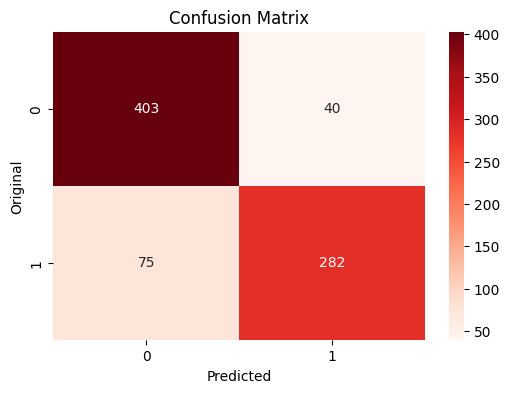

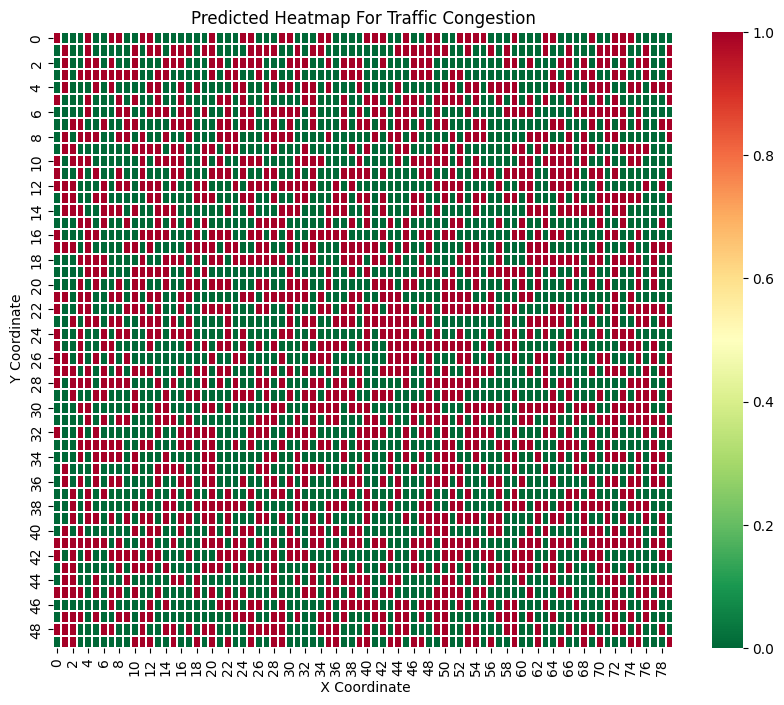

 TRAFFIC MANAGEMENT CHANGES 
      vehicle_density  Congestion_Probability  \
3995        33.904612                     1.0   
3994        42.853729                     1.0   
4           43.372854                     1.0   
3931        72.860305                     1.0   
3921        36.700422                     1.0   
...               ...                     ...   
3414        19.077729                     0.5   
2313        20.822027                     0.5   
2716        26.494884                     0.5   
1720        25.153028                     0.5   
33          25.580034                     0.5   

                                        Modified_Action  
3995  CRITICAL: Issue Reroute Alert & Force Red Ligh...  
3994  CRITICAL: Issue Reroute Alert & Force Red Ligh...  
4     CRITICAL: Issue Reroute Alert & Force Red Ligh...  
3931  CRITICAL: Issue Reroute Alert & Force Red Ligh...  
3921  CRITICAL: Issue Reroute Alert & Force Red Ligh...  
...                               

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# ------------ TASK 1 ------------

# --------------------
# 1. LOADING THE DATA
# --------------------

url= 'https://docs.google.com/spreadsheets/d/1z5WFArY9DnSyq854vktucDPxs6qvx8sYEDViOfVMp4M/gviz/tq?tvd=tab&tqx=out:csv&gid=0'
data=pd.read_csv(url)
df=pd.DataFrame(data)

# Some basic info for our data

data.head()
data.info()
print(data.describe())

# ----------------------------
# 2. PREPROCESSING & SPLIT
# ----------------------------

# 'Label' is our attcking column
# Drop spatial coordinates for training (we only use features describing the traffic physics)

X = df.drop(['label', 'tile_x', 'tile_y'], axis=1, errors='ignore')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------ TASK 2 ------------

# ---------
# 3. TRAIN
# ---------
# use of random forest is easier due to the identification of non-linear relationships
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


# --------------------
# EVALUATING THE DATA
# --------------------

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n Classification Report : ")
print(classification_report(y_test, y_pred))

print("\n ROC-AUC Score : ")
print(f"Score: {roc_auc_score (y_test, y_prob):.4f}")

# CONFUSION MATRIX

# we use confusion matrix so that it gives detailed prediction's done by the model
# we plot an heatmap to get a better understanding for the model
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Original')
plt.show()

# ------------ TASK 3 ------------

# ----------------------
# SPATIAL VISUALIZATION
# ----------------------

# Add dummy tile_x and tile_y columns to df for spatial visualization
# Assuming a grid for the 4000 data points, e.g., 50x80
num_rows = len(df)
grid_width = 80 # You can adjust this to change the grid shape
df['tile_x'] = df.index % grid_width
df['tile_y'] = df.index // grid_width

# Adds some predictions back to original dataframe

df['predicted_congestion'] = model.predict(df.drop(['label', 'tile_x', 'tile_y'], axis=1, errors='ignore'))

# Calculates the probability of congestion per tile location

heatmap_data = df.pivot_table(index='tile_y', columns='tile_x', values='predicted_congestion', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='RdYlGn_r', linewidths=0.1)

# 'RdYlGn_r' creates a Red-Yellow-Green map (red denotes highest congestion)

plt.title('Predicted Heatmap For Traffic Congestion')
plt.xlabel(' X Coordinate')
plt.ylabel(' Y Coordinate')
plt.show()

# ------------ TASK 4 ------------

# --------------------------------------
# INTERPRETATION FOR TRAFFIC CONGESTION
# --------------------------------------

# this command is used to decide how much congestion is there and how to manage it

# Calculate congestion probability for the full dataset using the trained model
df['Congestion_Probability'] = model.predict_proba(df[X.columns])[:, 1]

def recommend_intervention(row):

    prob = row['Congestion_Probability']

    if prob >= 0.80:
        return "CRITICAL: Issue Reroute Alert & Force Red Lights on Incoming"
    elif prob >= 0.50:
        return "MODERATE: Extend Green Signal Duration by 30s"
    else:
        return "NORMAL: Maintain Standard Cycle"

# we create a new column 'Modified _Action' in the dataset
df['Modified_Action'] = df.apply(recommend_intervention, axis=1)

# filter only the rows where action is needed
action_plan = df[df['Congestion_Probability'] >= 0.50].sort_values(by='Congestion_Probability', ascending=False)

print(" TRAFFIC MANAGEMENT CHANGES ")
print(action_plan[['vehicle_density', 'Congestion_Probability', 'Modified_Action']])

# this last print statements shows us summary of congestion
print("\n SUMMARY ")
print(df['Modified_Action'].value_counts())

# ------------ TASK 5 ------------

# This snippet of code tells us how speed vs no.of vehicles per km shows the next path

# Calculate mean values of features from X_train to use as defaults
mean_features = X_train.mean()

def traffic_interface():
    print(" LIVE TRAFFIC MONITORING ")
    try:
        speed = float(input("Enter current Road Speed (km/h): "))
        density = float(input("Enter current Vehicle Density (veh/km): "))

        # Create a DataFrame for prediction, filling other features with mean values
        input_data = pd.DataFrame(columns=X.columns)
        input_data.loc[0] = mean_features
        input_data.loc[0, 'avg_vehicle_speed'] = speed
        input_data.loc[0, 'vehicle_density'] = density

        # Prediction
        prediction = model.predict(input_data)[0]
        probability = model.predict_proba(input_data)[:, 1][0]

        if prediction == 1:
            print(f"\n ---ALERT--- High Congestion Detected! (Confidence: {probability*100:.1f}%)")
            print(" Reroute recommended")
        else:
            print(f"\n Traffic Flow is Normal. (Confidence: {(1-probability)*100:.1f}%)")

    except ValueError:
        print("Invalid input. Please enter numbers only.")

# Run the interface
traffic_interface()